In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
data = pd.read_csv("Amazon Sale Report.csv")

In [3]:
print(data['New'].count())
print(data['PendingS'].count())
data = data.drop(['New', 'PendingS'], axis=1)

0
0


In [4]:
cols_to_drop = [col for col in data.columns if data[col].nunique() <= 1]
print(cols_to_drop)
for col in cols_to_drop:
    print(f"{col}: {data[col].unique()}")
data = data.drop(['currency', 'ship-country'], axis=1)

['currency', 'ship-country', 'fulfilled-by']
currency: ['INR' nan]
ship-country: ['IN' nan]
fulfilled-by: ['Easy Ship' nan]


In [5]:
data['Date'].unique()
data['Date'] = pd.to_datetime(data['Date'], format='mixed')
data['Date'] = data['Date'].dt.month
data.rename(columns={'Date': 'Month'}, inplace=True)
print(data.columns)
print(data['Month'].head())

Index(['index', 'Order ID', 'Month', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty',
       'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'B2B',
       'fulfilled-by'],
      dtype='object')
0    4
1    4
2    4
3    4
4    4
Name: Month, dtype: int32


In [6]:
data = data.drop(['index', 'ship-postal-code'], axis=1)

In [7]:
chk_unique = ['Fulfilment','Sales Channel','Status','ship-service-level','Category','Size','Courier Status','ship-city','ship-state']
for i in chk_unique:
    print(data[i].unique())

['Merchant' 'Amazon']
['Amazon.in' 'Non-Amazon']
['Cancelled' 'Shipped - Delivered to Buyer' 'Shipped'
 'Shipped - Returned to Seller' 'Shipped - Rejected by Buyer'
 'Shipped - Lost in Transit' 'Shipped - Out for Delivery'
 'Shipped - Returning to Seller' 'Shipped - Picked Up' 'Pending'
 'Pending - Waiting for Pick Up' 'Shipped - Damaged' 'Shipping']
['Standard' 'Expedited']
['T-shirt' 'Shirt' 'Blazzer' 'Trousers' 'Perfume' 'Socks' 'Shoes' 'Wallet'
 'Watch']
['S' '3XL' 'XL' 'L' 'XXL' 'XS' '6XL' 'M' '4XL' 'Free' '5XL']
['On the Way' 'Shipped' 'Cancelled' 'Unshipped']
['MUMBAI' 'BENGALURU' 'NAVI MUMBAI' ... 'GULABPURA, Distt BHILWARA'
 'Prayagraj (ALLAHABAD)' 'Halol']
['MAHARASHTRA' 'KARNATAKA' 'PUDUCHERRY' 'TAMIL NADU' 'UTTAR PRADESH'
 'CHANDIGARH' 'TELANGANA' 'ANDHRA PRADESH' 'RAJASTHAN' 'DELHI' 'HARYANA'
 'ASSAM' 'JHARKHAND' 'CHHATTISGARH' 'ODISHA' 'KERALA' 'MADHYA PRADESH'
 'WEST BENGAL' 'NAGALAND' 'Gujarat' 'UTTARAKHAND' 'BIHAR'
 'JAMMU & KASHMIR' 'PUNJAB' 'HIMACHAL PRADESH' 'ARUNAC

In [8]:
data.rename(columns={'fulfilled-by': 'fulfilled_by'}, inplace=True)
data.rename(columns={'ship-service-level': 'ship_service_level'}, inplace=True)
data.rename(columns={'Sales Channel': 'Sales_Channel'}, inplace=True)
data.rename(columns={'Courier Status': 'Courier_Status'}, inplace=True)

In [9]:
data.B2B = (data.B2B == True).astype(int)
data.fulfilled_by = (data.fulfilled_by == "Easy Ship").astype(int)
data.ship_service_level = (data.ship_service_level == "Expedited").astype(int)
data.Fulfilment = (data.Fulfilment == "Amazon").astype(int)
data.Sales_Channel = (data.Sales_Channel == "Amazon.in").astype(int)

In [10]:
size_map = {
    'XS': 1, 'S': 2, 'M': 3, 'L': 4, 'XL': 5, 
    'XXL': 6, '3XL': 7, '4XL': 8, '5XL': 9, '6XL': 10, 'Free': 0
}
data['Size'] = data['Size'].map(size_map)

In [11]:
cstatus_map = {
    'On the Way':0.75, 'Shipped':1, 'Cancelled':0, 'Unshipped':0.25
}
data['Courier_Status'] = data['Courier_Status'].map(cstatus_map)

In [12]:
def sort_status(Status):
    if Status == 'Shipped - Delivered to Buyer':
        return 1
    elif Status in ['Shipped', 'Shipped - Out for Delivery', 'Shipped - Picked Up', 'Pending', 'Pending - Waiting for Pick Up', 'Shipping']:
        return 0.5
    elif Status in ['Cancelled', 'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer', 'Shipped - Lost in Transit', 'Shipped - Damaged', 'Shipped - Returning to Seller']:
        return 0
    else:
        return None
data['Status'] = data['Status'].apply(sort_status)

In [13]:
invalid_qty = data[(data['Qty'] == 0) & (data['Amount'] > 0)]
print(f"Rows with Ghost Orders (Qty=0, Amount>0): {len(invalid_qty)}")
free_items = data[(data['Qty'] > 0) & (data['Amount'] == 0)]
print(f"Free items/Promotions: {len(free_items)}")

Rows with Ghost Orders (Qty=0, Amount>0): 5134
Free items/Promotions: 2343


In [14]:
data.head()

,Order ID,Month,Status,Fulfilment,Sales_Channel,ship_service_level,Category,Size,Courier_Status,Qty,Amount,ship-city,ship-state,B2B,fulfilled_by
0,405-8078784-5731545,4,0.0,0,1,0,T-shirt,2,0.75,0,647.62,MUMBAI,MAHARASHTRA,0,1
1,171-9198151-1101146,4,1.0,0,1,0,Shirt,7,1.00,1,406.00,BENGALURU,KARNATAKA,0,1
2,404-0687676-7273146,4,0.5,1,1,1,Shirt,5,1.00,1,329.00,NAVI MUMBAI,MAHARASHTRA,1,0
3,403-9615377-8133951,4,0.0,0,1,0,Blazzer,4,0.75,0,753.33,PUDUCHERRY,PUDUCHERRY,0,1
4,407-1069790-7240320,4,0.5,1,1,1,Trousers,7,1.00,1,574.00,CHENNAI,TAMIL NADU,0,0


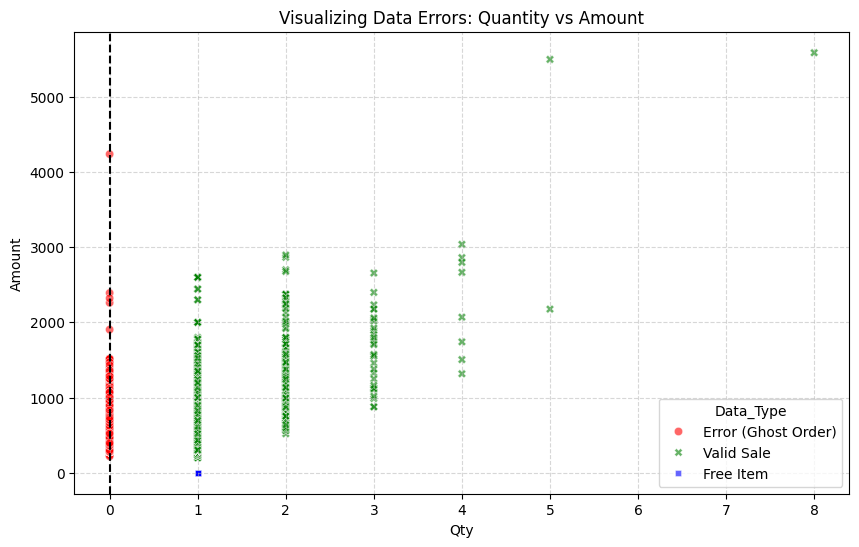

In [15]:
def categorize_row(row):
    if row['Qty'] == 0 and row['Amount'] > 0:
        return 'Error (Ghost Order)'  # These will be RED
    elif row['Qty'] > 0 and row['Amount'] == 0:
        return 'Free Item'            # These will be Blue/Green
    else:
        return 'Valid Sale'           # These will be Grey/Standard

data['Data_Type'] = data.apply(categorize_row, axis=1)


custom_colors = {
    'Error (Ghost Order)': 'red',
    'Valid Sale': 'green', 
    'Free Item': 'blue'
}


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data, 
    x='Qty', 
    y='Amount', 
    hue='Data_Type', 
    palette=custom_colors,
    style='Data_Type',  
    alpha=0.6           
)

plt.title("Visualizing Data Errors: Quantity vs Amount")
plt.axvline(x=0, color='black', linestyle='--') # Highlights the 0 line
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [16]:
ErrorOrders = data[(data['Qty'] == 0) & (data['Amount'] > 0)]
for col in ErrorOrders.columns:
    unique_vals = ErrorOrders[col].unique()
    if len(unique_vals) == 1:
        print(f"{col}: {unique_vals[0]}")

Status: 0.0
Fulfilment: 0
Sales_Channel: 1
ship_service_level: 0
Courier_Status: 0.75
Qty: 0
fulfilled_by: 1
Data_Type: Error (Ghost Order)


Data_Type  Error (Ghost Order)  Free Item  Valid Sale
Month                                                
3                            6          0         165
4                         2126        833       46109
5                         1711        748       39581
6                         1291        762       35644


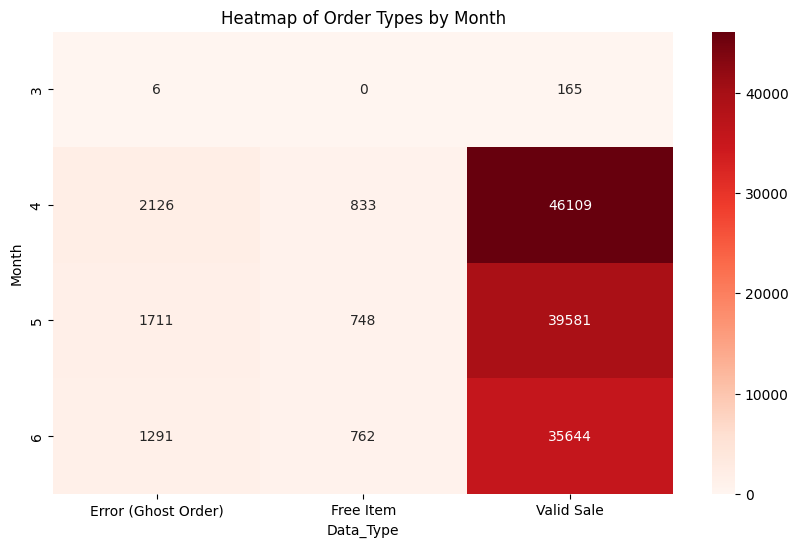

In [17]:
summary_table = pd.crosstab(data['Month'], data['Data_Type'])
print(summary_table)

plt.figure(figsize=(10, 6))
sns.heatmap(summary_table, annot=True, fmt='d', cmap='Reds')
plt.title("Heatmap of Order Types by Month")
plt.show()

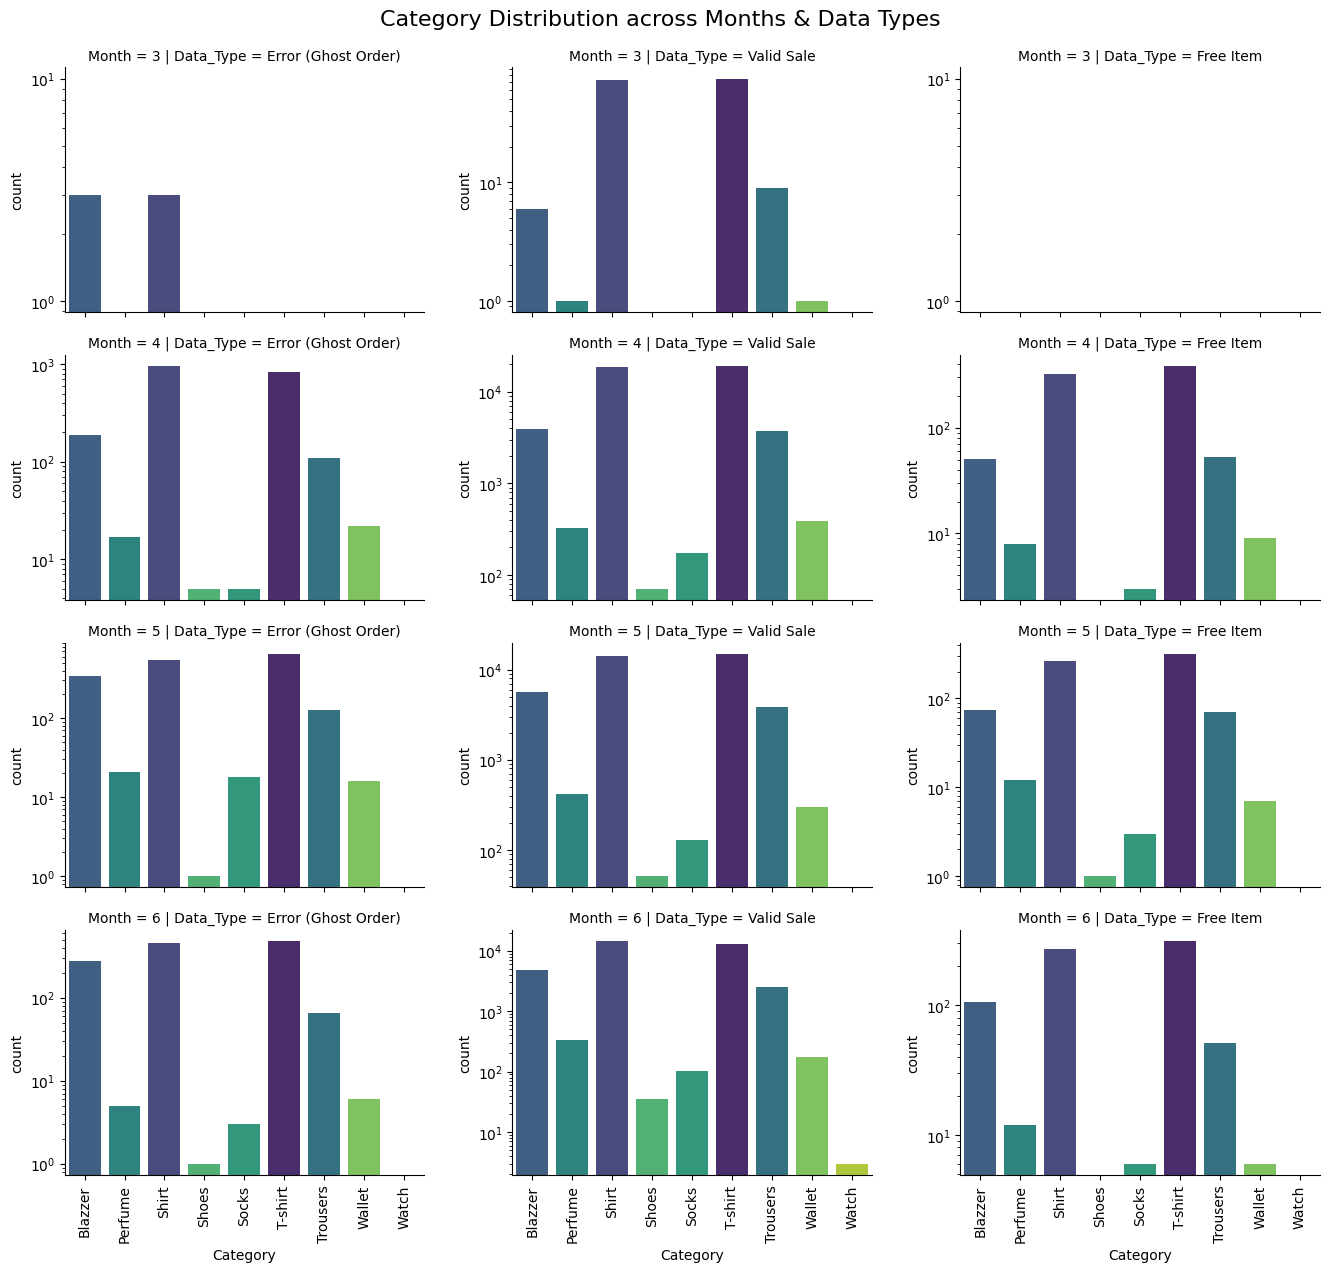

In [18]:
category_order = sorted(data['Category'].unique())
g = sns.FacetGrid(
    data, 
    row='Month', 
    col='Data_Type', 
    height=3, 
    aspect=1.5, 
    sharey=False, 
    sharex=True
)
g.map(sns.countplot, 'Category', order=category_order,hue=data['Category'], palette='viridis')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

g.fig.suptitle('Category Distribution across Months & Data Types', y=1.02, fontsize=16)
g.set(yscale="log")
plt.show()

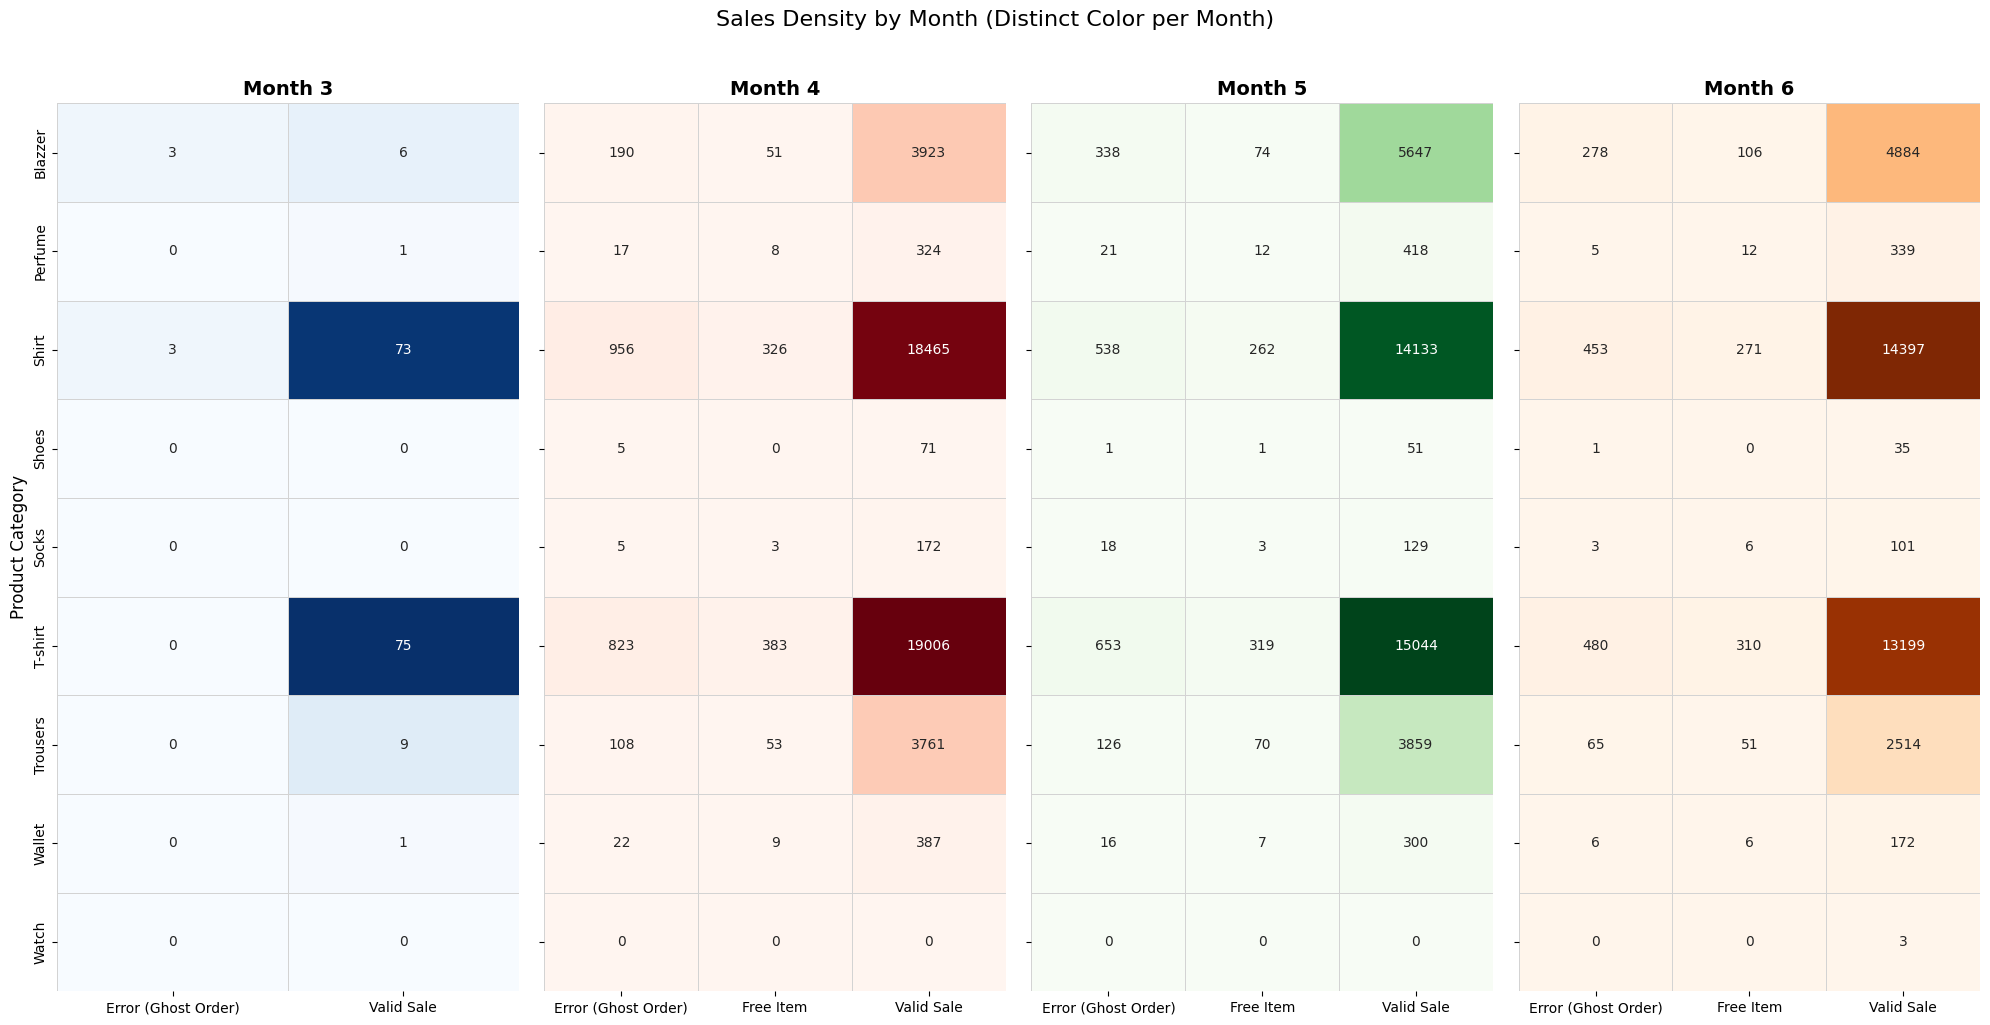

In [19]:
detailed_pivot = data.pivot_table(
    index='Category', 
    columns=['Month', 'Data_Type'], 
    values='Order ID', 
    aggfunc='count',
    fill_value=0
)

months = sorted(detailed_pivot.columns.get_level_values(0).unique())
n_months = len(months)

monthly_palettes = ['Blues', 'Reds', 'Greens', 'Oranges', 'Purples']

fig, axes = plt.subplots(1, n_months, figsize=(n_months * 5, 10), sharey=True)


for i, month in enumerate(months):
    ax = axes[i] if n_months > 1 else axes 
    month_data = detailed_pivot.xs(month, axis=1, level=0)
    cmap = monthly_palettes[i % len(monthly_palettes)]
    sns.heatmap(
        month_data, 
        annot=True, 
        fmt='d',         
        cmap=cmap,        
        ax=ax, 
        cbar=False,       
        linewidths=0.5,
        linecolor='lightgrey'
    )
    
    ax.set_title(f"Month {month}", fontsize=14, fontweight='bold')
    ax.set_xlabel("")
    
    if i == 0:
        ax.set_ylabel("Product Category", fontsize=12)
    else:
        ax.set_ylabel("")

plt.suptitle("Sales Density by Month (Distinct Color per Month)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [50]:
data['ship-state'] = data['ship-state'].str.upper().str.strip()
data['ship-city'] = data['ship-city'].str.upper().str.strip()
state_corrections = {
    'PB': 'PUNJAB', 
    'RJ': 'RAJASTHAN', 
    'RAJSTHAN': 'RAJASTHAN', 
    'DELHI': 'NEW DELHI', 
    'NL': 'NAGALAND', 
    'AR': 'ARUNACHAL PRADESH', 
    'ORISSA': 'ODISHA', 
    'PONDICHERRY': 'PUDUCHERRY',
    'GOA': 'GOA'
}
data['ship-state'] = data['ship-state'].replace(state_corrections)

# 3. Verify the clean list
#print(data['ship-state'].unique())
state_cleaner = {
    'RAJSHTHAN': 'RAJASTHAN',            # Fix typo
    'PUNJAB/MOHALI/ZIRAKPUR': 'PUNJAB',  # Standardize to State name
    'DADRA AND NAGAR': 'DADRA AND NAGAR HAVELI', # Fix incomplete name
    'APO': 'APO',                        # Keep (Army Post Office) - valid
    'NEW DELHI': 'DELHI'                 # Optional: Merge New Delhi into Delhi if you want
}

data['ship-state'] = data['ship-state'].replace(state_cleaner)
data['ship-state'].fillna('UNKNOWN', inplace=True)
data['ship-city'].fillna('UNKNOWN', inplace=True)

# 3. Verify the final list
print(data['ship-state'].unique())
print(data['ship-city'].unique())

['MAHARASHTRA' 'KARNATAKA' 'PUDUCHERRY' 'TAMIL NADU' 'UTTAR PRADESH'
 'CHANDIGARH' 'TELANGANA' 'ANDHRA PRADESH' 'RAJASTHAN' 'DELHI' 'HARYANA'
 'ASSAM' 'JHARKHAND' 'CHHATTISGARH' 'ODISHA' 'KERALA' 'MADHYA PRADESH'
 'WEST BENGAL' 'NAGALAND' 'GUJARAT' 'UTTARAKHAND' 'BIHAR'
 'JAMMU & KASHMIR' 'PUNJAB' 'HIMACHAL PRADESH' 'ARUNACHAL PRADESH' 'GOA'
 'MEGHALAYA' 'MANIPUR' 'TRIPURA' 'LADAKH' 'DADRA AND NAGAR HAVELI'
 'SIKKIM' 'UNKNOWN' 'ANDAMAN & NICOBAR' 'MIZORAM' 'LAKSHADWEEP' 'APO']
['MUMBAI' 'BENGALURU' 'NAVI MUMBAI' ... 'CHERUKUNNU (P.O)'
 'GULABPURA, DISTT BHILWARA' 'PRAYAGRAJ (ALLAHABAD)']


C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\1786591606.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ship-state'].fillna('UNKNOWN', inplace=True)
C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\1786591606.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [49]:
location_stats = data.groupby(['ship-state', 'ship-city', 'Data_Type'])['Order ID'].count().unstack().fillna(0)

top_cities_sales = location_stats.sort_values(by='Valid Sale', ascending=False)
#.head(10)

top_cities_errors = location_stats.sort_values(by='Error (Ghost Order)', ascending=False).head(10)

print("--- TOP 10 CITIES FOR SALES ---")
print(top_cities_sales[['Valid Sale', 'Error (Ghost Order)', 'Free Item']])

print("\n--- TOP 10 CITIES FOR ERRORS ---")
print(top_cities_errors[['Error (Ghost Order)', 'Valid Sale']])

--- TOP 10 CITIES FOR SALES ---
Data_Type                                      Valid Sale  \
ship-state  ship-city                                       
KARNATAKA   BENGALURU                             11335.0   
TELANGANA   HYDERABAD                              8614.0   
MAHARASHTRA MUMBAI                                 6721.0   
TAMIL NADU  CHENNAI                                5962.0   
DELHI       NEW DELHI                              5944.0   
...                                                   ...   
KERALA      CALICUT,PIN-673008                        0.0   
            CEPZ PO, KAKKANAD ,KOCHI                  0.0   
            INFOPARK ROAD, INFOPARK, KAKKANAD         0.0   
            CHENGUVETTY                               0.0   
            EDACHIRA,KAKKANAD                         0.0   

Data_Type                                      Error (Ghost Order)  Free Item  
ship-state  ship-city                                                          
KARNATAKA   BE

In [51]:
location_audit = data.pivot_table(
    index=['ship-state'],#'ship-city'], 
    columns='Data_Type', 
    values='Order ID', 
    aggfunc='count', 
    fill_value=0
)

if 'Valid Sale' in location_audit.columns:
    zero_sale_locs = location_audit[location_audit['Valid Sale'] == 0].copy()
else:
    zero_sale_locs = location_audit.copy()

if 'Error (Ghost Order)' in zero_sale_locs.columns:
    zero_sale_locs = zero_sale_locs.sort_values(by='Error (Ghost Order)', ascending=False)

print(f"Total Locations with 0 Valid Sales: {len(zero_sale_locs)}")

print(zero_sale_locs)
#.head(20))


Total Locations with 0 Valid Sales: 0
Empty DataFrame
Columns: [Error (Ghost Order), Free Item, Valid Sale]
Index: []


C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\33480972.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ghost_city_counts.index, y=ghost_city_counts.values, palette="Reds_d")


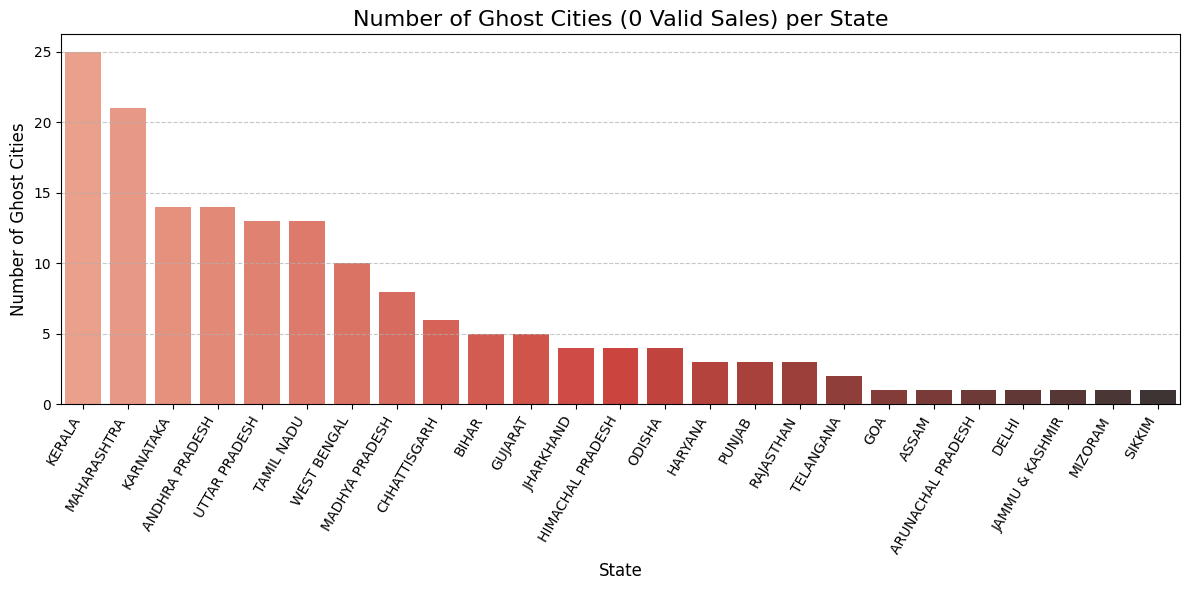

Ghost City Count by State (Top 10):
ship-state
KERALA               25
MAHARASHTRA          21
KARNATAKA            14
ANDHRA PRADESH       14
UTTAR PRADESH        13
TAMIL NADU           13
WEST BENGAL          10
MADHYA PRADESH        8
CHHATTISGARH          6
BIHAR                 5
GUJARAT               5
JHARKHAND             4
HIMACHAL PRADESH      4
ODISHA                4
HARYANA               3
PUNJAB                3
RAJASTHAN             3
TELANGANA             2
GOA                   1
ASSAM                 1
ARUNACHAL PRADESH     1
DELHI                 1
JAMMU & KASHMIR       1
MIZORAM               1
SIKKIM                1
dtype: int64


In [52]:
city_scorecard = data.pivot_table(
    index=['ship-state', 'ship-city'], 
    columns='Data_Type', 
    values='Order ID', 
    aggfunc='count', 
    fill_value=0
)

if 'Valid Sale' in city_scorecard.columns:
    ghost_cities_df = city_scorecard[city_scorecard['Valid Sale'] == 0].copy()
else:
    
    ghost_cities_df = city_scorecard.copy()

ghost_city_counts = ghost_cities_df.groupby(level=0).size()


ghost_city_counts = ghost_city_counts.sort_values(ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x=ghost_city_counts.index, y=ghost_city_counts.values, palette="Reds_d")

plt.title("Number of Ghost Cities (0 Valid Sales) per State", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Number of Ghost Cities", fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("ghost_cities_by_state.png")
plt.show()

print("Ghost City Count by State (Top 10):")
print(ghost_city_counts)#.head(10))

C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\3938909516.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=valid_city_counts.index, y=valid_city_counts.values, palette="Reds_d")


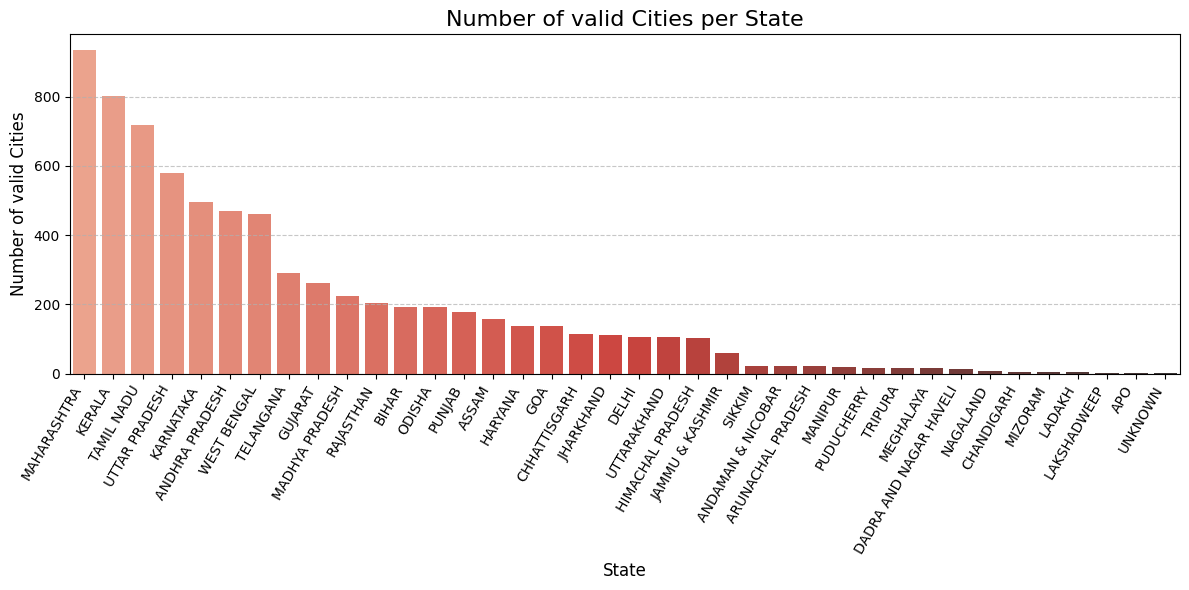

valid City Count by State:
ship-state
MAHARASHTRA               933
KERALA                    803
TAMIL NADU                718
UTTAR PRADESH             579
KARNATAKA                 495
ANDHRA PRADESH            471
WEST BENGAL               460
TELANGANA                 290
GUJARAT                   262
MADHYA PRADESH            225
RAJASTHAN                 205
BIHAR                     194
ODISHA                    193
PUNJAB                    178
ASSAM                     157
HARYANA                   138
GOA                       137
CHHATTISGARH              116
JHARKHAND                 111
DELHI                     106
UTTARAKHAND               105
HIMACHAL PRADESH          104
JAMMU & KASHMIR            60
SIKKIM                     22
ANDAMAN & NICOBAR          22
ARUNACHAL PRADESH          22
MANIPUR                    20
PUDUCHERRY                 18
TRIPURA                    16
MEGHALAYA                  16
DADRA AND NAGAR HAVELI     13
NAGALAND                    8
CH

In [53]:
city_scorecard = data.pivot_table(
    index=['ship-state', 'ship-city'], 
    columns='Data_Type', 
    values='Order ID', 
    aggfunc='count', 
    fill_value=0
)

if 'Valid Sale' in city_scorecard.columns:
    valid_cities_df = city_scorecard[city_scorecard['Valid Sale'] > 0].copy()
else:
    
    valid_cities_df = city_scorecard.copy()

valid_city_counts = valid_cities_df.groupby(level=0).size()


valid_city_counts = valid_city_counts.sort_values(ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x=valid_city_counts.index, y=valid_city_counts.values, palette="Reds_d")

plt.title("Number of valid Cities per State", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Number of valid Cities", fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("valid_cities_by_state.png")
plt.show()

print("valid City Count by State:")
print(valid_city_counts)#.head(10))

In [55]:
# 1. Create the base statistics (Group by State & City)
location_stats = data.groupby(['ship-state', 'ship-city', 'Data_Type'])['Order ID'].count().unstack().fillna(0)

# --- THE FIX: Filter for Valid Cities ---
# We only keep rows where 'Valid Sale' is greater than 0
valid_cities_stats = location_stats[location_stats['Valid Sale'] > 0]

# 2. Sort the CLEANED data
top_cities_sales = valid_cities_stats.sort_values(by='Valid Sale', ascending=False)
top_cities_errors = valid_cities_stats.sort_values(by='Error (Ghost Order)', ascending=False).head(10)

# 3. Print the results
print(f"Original Cities Count: {len(location_stats)}")
print(f"Valid Cities Count: {len(valid_cities_stats)}")
print(f"Dropped (Ghost) Cities: {len(location_stats) - len(valid_cities_stats)}")
print("-" * 50)

print("--- TOP 10 CITIES FOR SALES (Verified Locations) ---")
# displaying head(20) to see more
print(top_cities_sales[['Valid Sale', 'Error (Ghost Order)', 'Free Item']])
#.head(20))

print("\n--- TOP 10 CITIES FOR ERRORS (Verified Locations) ---")
# These are real cities that have high sales but ALSO high errors
print(top_cities_errors[['Error (Ghost Order)', 'Valid Sale']])

Original Cities Count: 7380
Valid Cities Count: 7216
Dropped (Ghost) Cities: 164
--------------------------------------------------
--- TOP 10 CITIES FOR SALES (Verified Locations) ---
Data_Type                                        Valid Sale  \
ship-state     ship-city                                      
KARNATAKA      BENGALURU                            11335.0   
TELANGANA      HYDERABAD                             8614.0   
MAHARASHTRA    MUMBAI                                6721.0   
TAMIL NADU     CHENNAI                               5962.0   
DELHI          NEW DELHI                             5944.0   
...                                                     ...   
ANDHRA PRADESH ALLAGADDA                                1.0   
               AINAVILLI MANDAL, EAST GODHAVARI         1.0   
               ADDANKI MANDAL BAPATL DISTRICT           1.0   
WEST BENGAL    UTTARPARA                                1.0   
               UTTARNAYABAD                             1.0

--- Trending Products in Top Cities ---
           ship-state   ship-city Category  Order ID
3533        KARNATAKA   BENGALURU    Shirt      4208
9924        TELANGANA   HYDERABAD    Shirt      3423
8796       TAMIL NADU     CHENNAI    Shirt      2828
1811            DELHI   NEW DELHI  T-shirt      2582
6725      MAHARASHTRA      MUMBAI  T-shirt      2420
...               ...         ...      ...       ...
12145     WEST BENGAL  SONATIKIRI  T-shirt         1
12144     WEST BENGAL    SONATALA    Shirt         1
12141     WEST BENGAL   SONAMUKHI    Shirt         1
54     ANDHRA PRADESH   ALLAVARAM  T-shirt         1
53     ANDHRA PRADESH   ALLAGADDA    Shirt         1

[7010 rows x 4 columns]


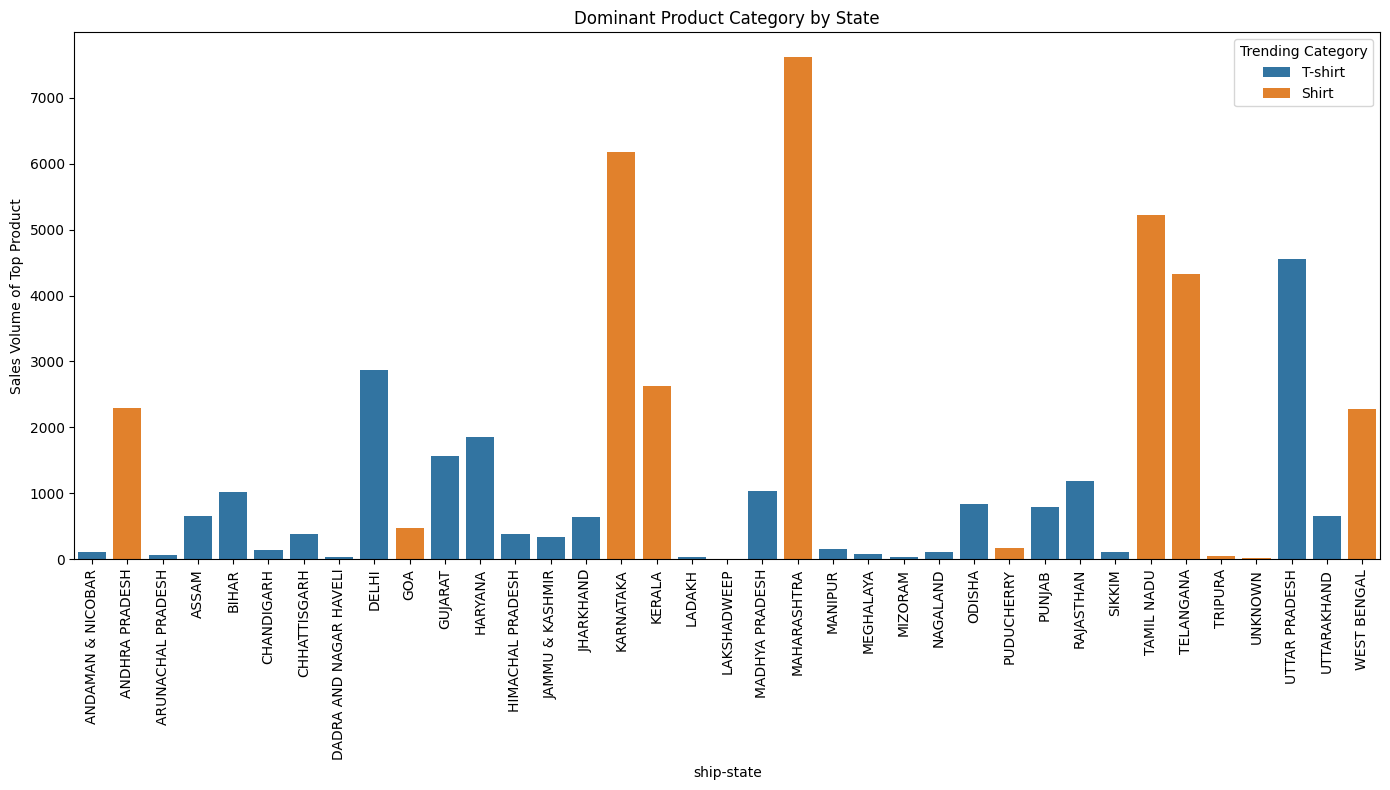

In [59]:

valid_sales = data[data['Qty'] > 0].copy()

# 2. Count Sales per Category in each City
#    Group by [State, City, Category] -> Count Order IDs
cat_counts = valid_sales.groupby(['ship-state', 'ship-city', 'Category'])['Order ID'].count().reset_index()

# 3. Rename column for clarity
#cat_counts.rename(columns={'Order ID': 'Sales_Count'}, inplace=True)

# 4. Sort to find the winner
#    Sort by City (A-Z) and Sales_Count (High-Low)
cat_counts.sort_values(by=['ship-state', 'ship-city', 'Order ID'], ascending=[True, True, False], inplace=True)

# 5. Drop duplicates to keep ONLY the #1 Category per City
#    Since we sorted by Count descending, the first row for each city is the winner.
trending_by_city = cat_counts.drop_duplicates(subset=['ship-state', 'ship-city'])

# 6. View the Results (Top 15 Cities by Sales Volume)
#    We sort by Sales_Count again just to see the biggest markets first
print("--- Trending Products in Top Cities ---")
print(trending_by_city.sort_values(by='Order ID', ascending=False))
#.head(15))


# 1. Find the Trending Category per STATE (Easier to read)
state_counts = valid_sales.groupby(['ship-state', 'Category'])['Order ID'].count().reset_index()
state_counts.sort_values(by=['ship-state', 'Order ID'], ascending=[True, False], inplace=True)
trending_by_state = state_counts.drop_duplicates(subset=['ship-state'])

# 2. Plot: "What is the favorite product of each State?"
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.barplot(
    data=trending_by_state, 
    x='ship-state', 
    y='Order ID', 
    hue='Category', # This colors the bars based on the Winner Product
    dodge=False     # Stack bars so they are easier to read
)

plt.title("Dominant Product Category by State")
plt.xticks(rotation=90)
plt.ylabel("Sales Volume of Top Product")
plt.legend(title="Trending Category")
plt.tight_layout()
plt.show()

--- Top 10 States by Average Order Value (AOV) ---
          ship-state  Amount
17            LADAKH  941.97
24          NAGALAND  814.70
18       LAKSHADWEEP  813.67
29            SIKKIM  749.15
4              BIHAR  738.40
12  HIMACHAL PRADESH  724.63
21           MANIPUR  722.93
13   JAMMU & KASHMIR  721.09
28         RAJASTHAN  710.47
25            ODISHA  709.18


C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\2798586036.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_avg, x='ship-state', y='Amount', palette='Greens_r')


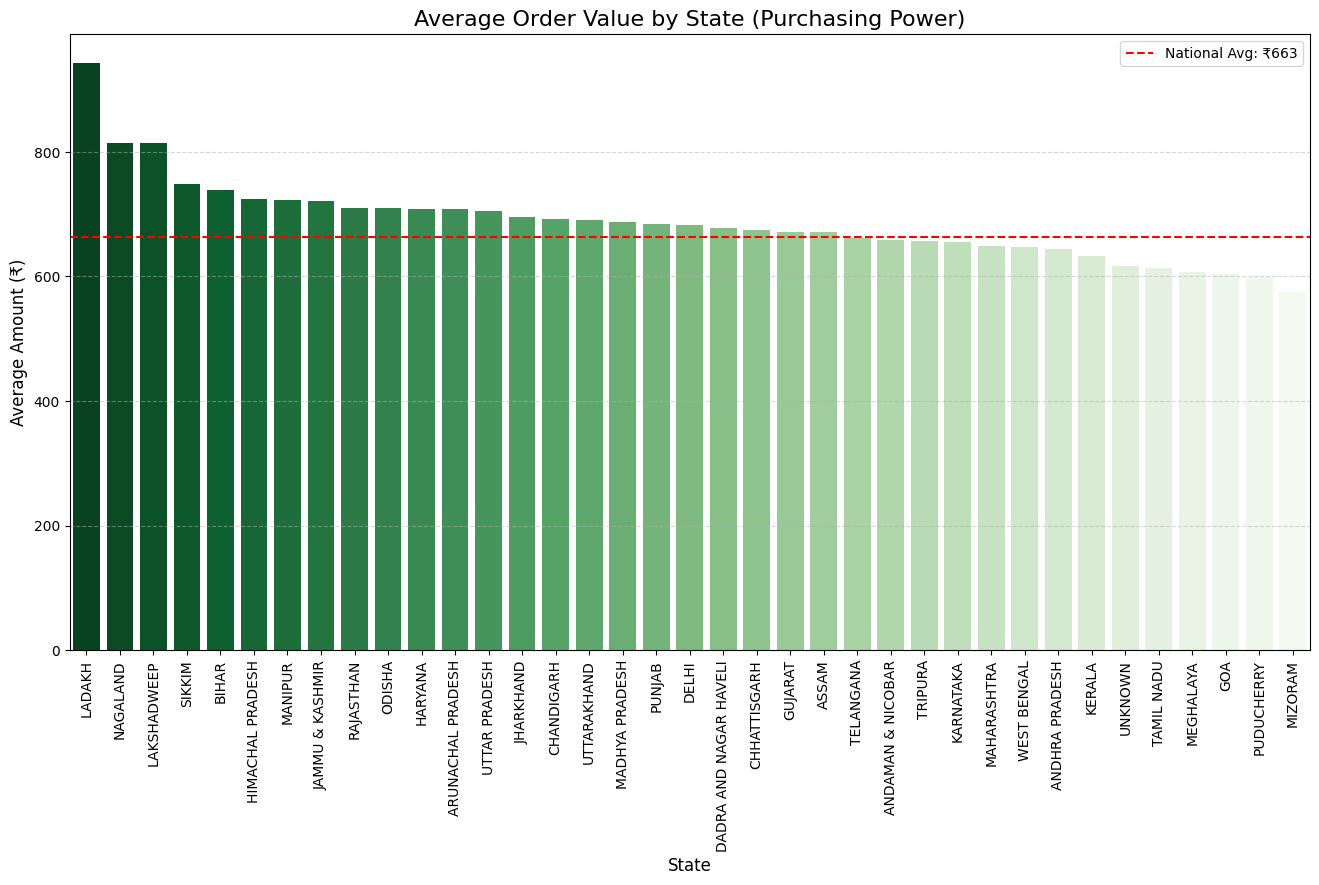

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter for Valid Sales only (Qty > 0)
#    We don't want "Ghost Orders" (Qty=0) or "Free Items" (Amount=0) dragging the average down.
valid_sales = data[(data['Qty'] > 0) & (data['Amount'] > 0)]

# 2. Calculate Average Amount per State
state_avg = valid_sales.groupby('ship-state')['Amount'].mean().reset_index()

# 3. Sort from Highest to Lowest (Richest orders first)
state_avg.sort_values(by='Amount', ascending=False, inplace=True)

# 4. Display the Top 10 States with highest spending power
print("--- Top 10 States by Average Order Value (AOV) ---")
print(state_avg.head(10).round(2))

# 5. Plot the Bar Chart
plt.figure(figsize=(16, 8))
sns.barplot(data=state_avg, x='ship-state', y='Amount', palette='Greens_r')

plt.title("Average Order Value by State (Purchasing Power)", fontsize=16)
plt.ylabel("Average Amount (₹)", fontsize=12)
plt.xlabel("State", fontsize=12)
plt.xticks(rotation=90) # Rotate labels
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add a horizontal line for the National Average
national_avg = valid_sales['Amount'].mean()
plt.axhline(y=national_avg, color='red', linestyle='--', label=f'National Avg: ₹{national_avg:.0f}')
plt.legend()

plt.show()

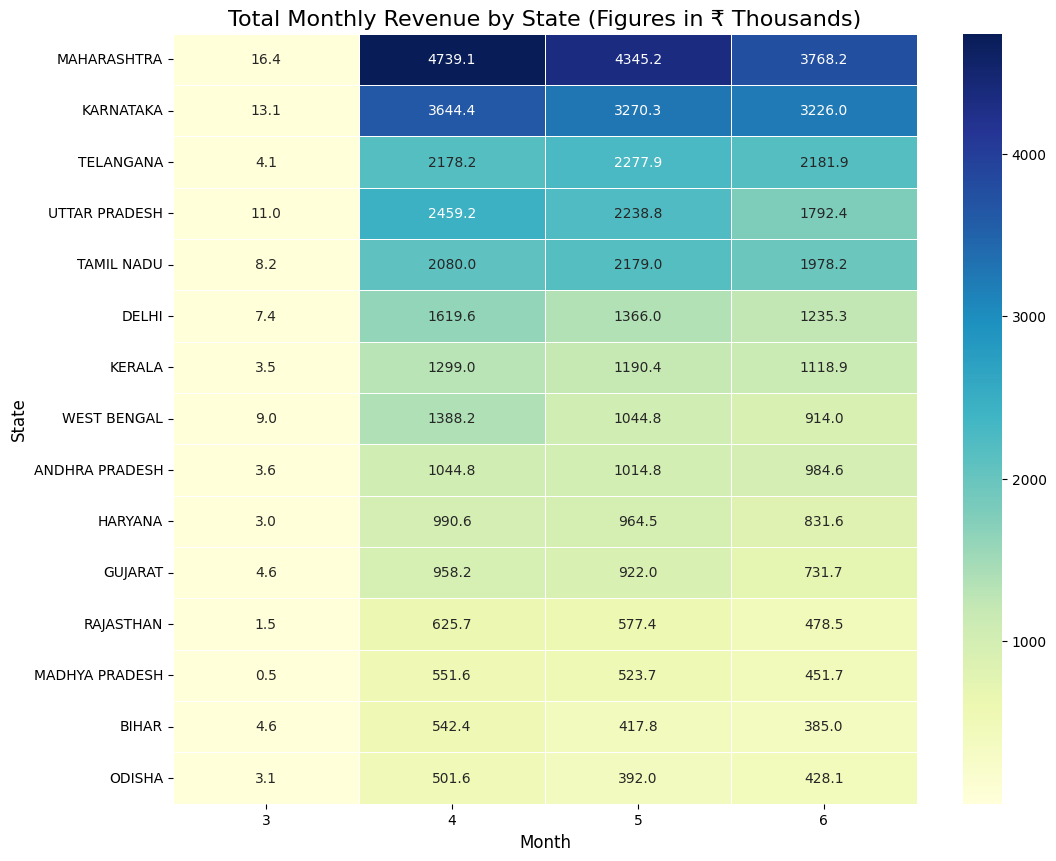

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filter for Valid Sales only (Real money)
valid_sales = data[(data['Qty'] > 0) & (data['Amount'] > 0)]

# 2. Pivot Table: State vs Month -> Sum of Amount
#    This creates a matrix where cells = Total Revenue
monthly_state_sales = valid_sales.pivot_table(
    index='ship-state', 
    columns='Month', 
    values='Amount', 
    aggfunc='sum',
    fill_value=0
)

# 3. Filter: Keep only the Top 15 States by Total Revenue
#    (Plotting all 30+ states makes the chart unreadable)
top_states = monthly_state_sales.sum(axis=1).nlargest(15).index
monthly_state_sales = monthly_state_sales.loc[top_states]

# 4. Plot the Heatmap
plt.figure(figsize=(12, 10))

# We divide by 1000 to show figures in 'Thousands' (K) for readability
sns.heatmap(
    monthly_state_sales / 1000, 
    annot=True, 
    fmt=".1f", # Show 1 decimal place (e.g., 50.5 K)
    cmap='YlGnBu', 
    linewidths=0.5
)

plt.title("Total Monthly Revenue by State (Figures in ₹ Thousands)", fontsize=16)
plt.ylabel("State", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

Volume Leaders (Mass Market): ['MAHARASHTRA', 'KARNATAKA', 'TAMIL NADU', 'TELANGANA', 'UTTAR PRADESH']
Value Leaders (Premium Market): ['LADAKH', 'NAGALAND', 'LAKSHADWEEP', 'SIKKIM', 'BIHAR']


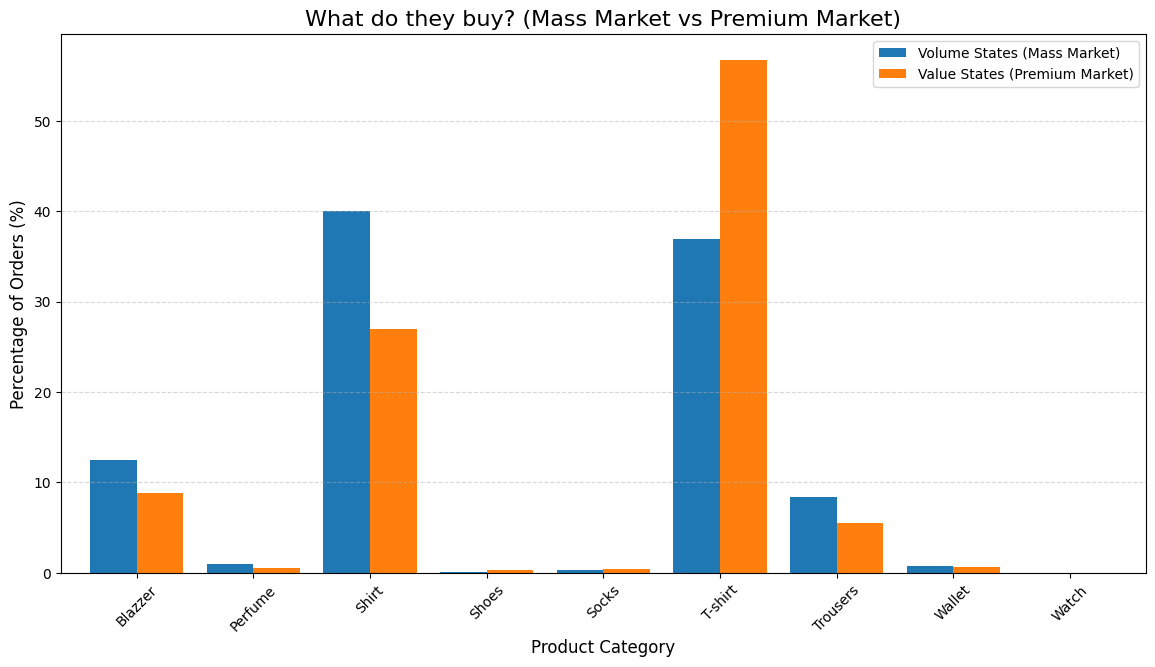

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Define your two groups
# Group A: Volume Leaders (Top 5 states by Total Order Count)
volume_states = valid_sales['ship-state'].value_counts().nlargest(5).index.tolist()

# Group B: Value Leaders (Top 5 states by Average Order Value)
# We calculate mean amount per state again to be sure
state_avg = valid_sales.groupby('ship-state')['Amount'].mean()
value_states = state_avg.nlargest(5).index.tolist()

print(f"Volume Leaders (Mass Market): {volume_states}")
print(f"Value Leaders (Premium Market): {value_states}")

# 2. Filter data for these groups
volume_data = valid_sales[valid_sales['ship-state'].isin(volume_states)].copy()
value_data = valid_sales[valid_sales['ship-state'].isin(value_states)].copy()

# 3. Calculate Category Percentage for each group
# We want to see: "What % of their orders are T-shirts?"
vol_cat_dist = volume_data['Category'].value_counts(normalize=True) * 100
val_cat_dist = value_data['Category'].value_counts(normalize=True) * 100

# 4. Combine into one DataFrame for plotting
comparison_df = pd.DataFrame({
    'Volume States (Mass Market)': vol_cat_dist,
    'Value States (Premium Market)': val_cat_dist
}).fillna(0) # Fill NaN with 0 if a category wasn't bought at all

# 5. Plot Side-by-Side Bar Chart
comparison_df.plot(kind='bar', figsize=(14, 7), width=0.8, color=['#1f77b4', '#ff7f0e'])

plt.title("What do they buy? (Mass Market vs Premium Market)", fontsize=16)
plt.ylabel("Percentage of Orders (%)", fontsize=12)
plt.xlabel("Product Category", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()

plt.show()

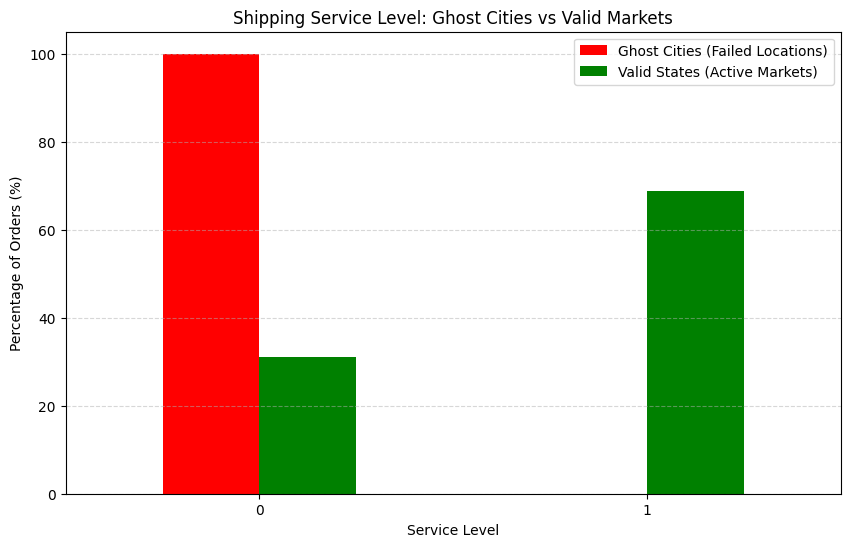

--- Ghost Cities Service Mix ---
ship_service_level
0    100.0
Name: proportion, dtype: float64

--- Valid Markets Service Mix ---
ship_service_level
1    68.8
0    31.2
Name: proportion, dtype: float64


In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define your two groups
# Group A: Ghost Cities (Cities with 0 Valid Sales)
# We re-use the 'location_pivot' logic to find them
location_pivot = data.pivot_table(
    index=['ship-state', 'ship-city'], 
    columns='Data_Type', 
    values='Order ID', 
    aggfunc='count', 
    fill_value=0
)

# Identify the index (State, City) for both groups
if 'Valid Sale' in location_pivot.columns:
    ghost_indices = location_pivot[location_pivot['Valid Sale'] == 0].index
    valid_indices = location_pivot[location_pivot['Valid Sale'] > 0].index
else:
    ghost_indices = location_pivot.index
    valid_indices = []

# 2. Filter the main data
# We set the index temporarily to filter fast
data_indexed = data.set_index(['ship-state', 'ship-city'])

ghost_data = data_indexed.loc[data_indexed.index.isin(ghost_indices)]
valid_data = data_indexed.loc[data_indexed.index.isin(valid_indices)]

# 3. Calculate the Percentages
# We normalize=True to get percentages, then * 100
ghost_service_dist = ghost_data['ship_service_level'].value_counts(normalize=True) * 100
valid_service_dist = valid_data['ship_service_level'].value_counts(normalize=True) * 100

# 4. Combine and Plot
comparison_df = pd.DataFrame({
    'Ghost Cities (Failed Locations)': ghost_service_dist,
    'Valid States (Active Markets)': valid_service_dist
}).fillna(0) # Fill 0 if a service level is missing

# Plot
comparison_df.plot(kind='bar', figsize=(10, 6), color=['red', 'green'])

plt.title("Shipping Service Level: Ghost Cities vs Valid Markets")
plt.ylabel("Percentage of Orders (%)")
plt.xlabel("Service Level")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# 5. Print exact numbers
print("--- Ghost Cities Service Mix ---")
print(ghost_service_dist.round(1))
print("\n--- Valid Markets Service Mix ---")
print(valid_service_dist.round(1))

--- B2B vs B2C Scorecard ---
   Is_B2B  Total_Orders  Total_Revenue  Avg_Order_Value  Total_Qty  \
0       0        128104    77998690.46           648.20     115805   
1       1           872      591479.79           700.81        841   

   Valid_Orders  Success_Rate (%)  
0        115340             90.04  
1           826             94.72  


C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\509886053.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Is_B2B', y='Avg_Order_Value', data=b2b_analysis, ax=axes[0], palette='magma')
C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\509886053.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['B2C (Consumer)', 'B2B (Business)'])
C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\509886053.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Is_B2B', y='Success_Rate (%)', data=b2b_analysis, ax=axes[1], palette='coolwarm')
C:\Users\karthik\AppData\Local\Temp\ipyke

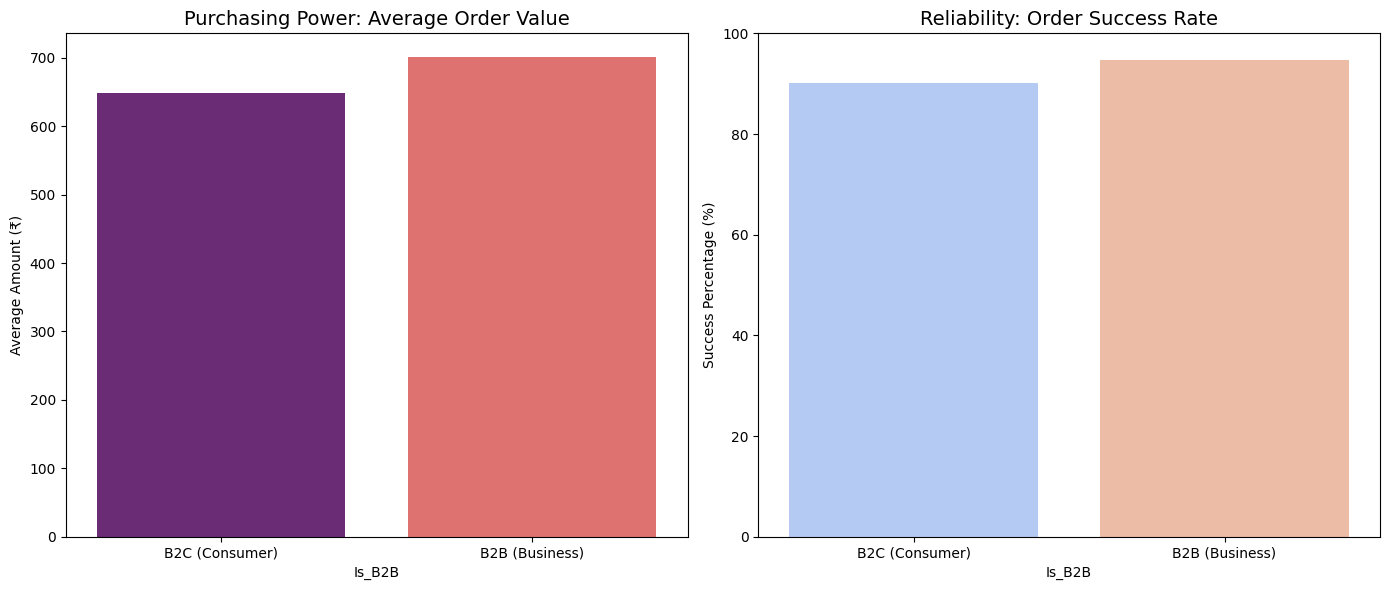

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Check if B2B column exists
if 'B2B' in data.columns:
    # 2. Group by B2B Status
    #    B2B = True (Business), B2B = False (Consumer)
    b2b_analysis = data.groupby('B2B').agg({
        'Order ID': 'count',          # Total Orders
        'Amount': ['sum', 'mean'],    # Total Revenue & Average Order Value
        'Qty': 'sum'                  # Total Items Sold
    }).reset_index()

    # Flatten the column names for easier access
    b2b_analysis.columns = ['Is_B2B', 'Total_Orders', 'Total_Revenue', 'Avg_Order_Value', 'Total_Qty']

    # 3. Calculate "Reliability" (Cancellation Rate)
    #    We check what % of orders in each group ended up as "Valid Sales" (Qty > 0)
    #    First, count valid sales per group
    valid_counts = data[data['Qty'] > 0].groupby('B2B')['Order ID'].count()
    
    #    Map it back
    b2b_analysis['Valid_Orders'] = b2b_analysis['Is_B2B'].map(valid_counts)
    b2b_analysis['Success_Rate (%)'] = (b2b_analysis['Valid_Orders'] / b2b_analysis['Total_Orders']) * 100

    # 4. Print the Scorecard
    print("--- B2B vs B2C Scorecard ---")
    print(b2b_analysis.round(2))

    # 5. Visual Comparison (Side-by-Side Charts)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Chart 1: Average Order Value (Who spends more?)
    sns.barplot(x='Is_B2B', y='Avg_Order_Value', data=b2b_analysis, ax=axes[0], palette='magma')
    axes[0].set_title("Purchasing Power: Average Order Value", fontsize=14)
    axes[0].set_ylabel("Average Amount (₹)")
    axes[0].set_xticklabels(['B2C (Consumer)', 'B2B (Business)'])

    # Chart 2: Success Rate (Who cancels less?)
    sns.barplot(x='Is_B2B', y='Success_Rate (%)', data=b2b_analysis, ax=axes[1], palette='coolwarm')
    axes[1].set_title("Reliability: Order Success Rate", fontsize=14)
    axes[1].set_ylabel("Success Percentage (%)")
    axes[1].set_xticklabels(['B2C (Consumer)', 'B2B (Business)'])
    axes[1].set_ylim(0, 100) # Scale from 0 to 100%

    plt.tight_layout()
    plt.show()

else:
    print("B2B Column not found in dataset.")

--- Percentage of Ghost Orders (Failure Rate) ---
B2B
0    3.99
1    2.06
Name: Is_Ghost, dtype: float64
(Interpretation: Higher number = More Technical Glitches/Returns)

--- B2B Adoption Rate ---
Volume States (Mass Market): 0.71% B2B Orders
Value States (Premium Market): 0.12% B2B Orders


C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\3872087360.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ghost_analysis.index, y=ghost_analysis.values, ax=axes[0], palette='Reds')
C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\3872087360.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['B2C (Consumer)', 'B2B (Business)'])
C:\Users\karthik\AppData\Local\Temp\ipykernel_12956\3872087360.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_types, y=b2b_rates, ax=axes[1], palette='Blues')


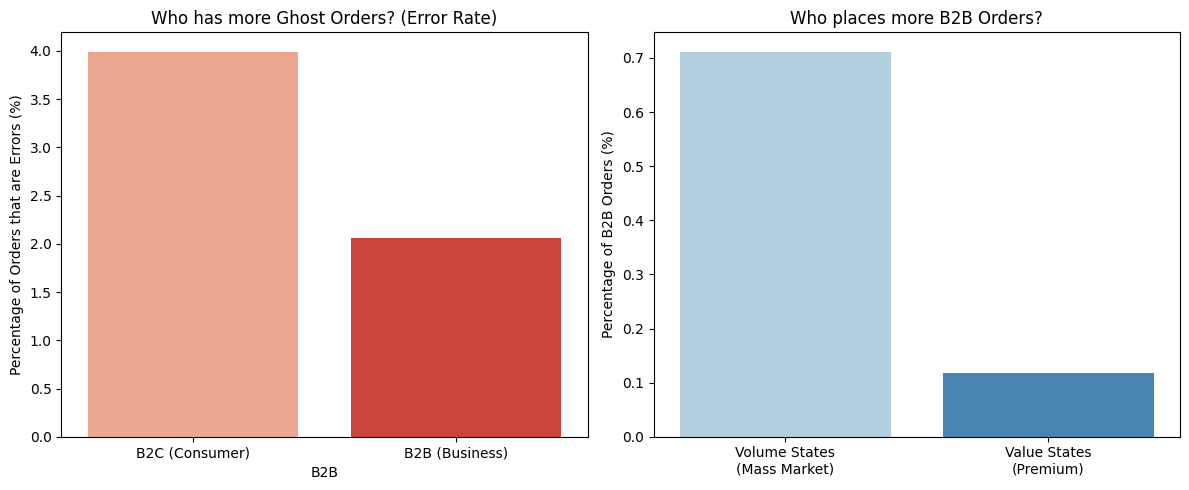

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- PART 1: Who causes more Ghost Orders? ---
# 1. Flag Ghost Orders (Qty=0, Amount>0)
data['Is_Ghost'] = (data['Qty'] == 0) & (data['Amount'] > 0)

# 2. Calculate Ghost Rate per Group
#    Group by B2B -> Calculate mean of 'Is_Ghost' (True=1, False=0)
ghost_analysis = data.groupby('B2B')['Is_Ghost'].mean() * 100

print("--- Percentage of Ghost Orders (Failure Rate) ---")
print(ghost_analysis.round(2))
print("(Interpretation: Higher number = More Technical Glitches/Returns)\n")


# --- PART 2: State Preferences (Volume vs Value Leaders) ---
# 1. Define your leaders again (if not already defined)
#    Volume = Top 5 by Count, Value = Top 5 by AOV
top_volume_states = data['ship-state'].value_counts().nlargest(5).index
top_value_states = data[data['Qty']>0].groupby('ship-state')['Amount'].mean().nlargest(5).index

# 2. Filter data for these groups
vol_data = data[data['ship-state'].isin(top_volume_states)]
val_data = data[data['ship-state'].isin(top_value_states)]

# 3. Calculate B2B Percentage for each group
#    How many orders in these states are B2B?
vol_b2b_pct = vol_data['B2B'].mean() * 100
val_b2b_pct = val_data['B2B'].mean() * 100

print(f"--- B2B Adoption Rate ---")
print(f"Volume States (Mass Market): {vol_b2b_pct:.2f}% B2B Orders")
print(f"Value States (Premium Market): {val_b2b_pct:.2f}% B2B Orders")

# 4. Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Ghost Rate
sns.barplot(x=ghost_analysis.index, y=ghost_analysis.values, ax=axes[0], palette='Reds')
axes[0].set_title("Who has more Ghost Orders? (Error Rate)")
axes[0].set_ylabel("Percentage of Orders that are Errors (%)")
axes[0].set_xticklabels(['B2C (Consumer)', 'B2B (Business)'])

# Plot 2: B2B Preference by State Type
state_types = ['Volume States\n(Mass Market)', 'Value States\n(Premium)']
b2b_rates = [vol_b2b_pct, val_b2b_pct]

sns.barplot(x=state_types, y=b2b_rates, ax=axes[1], palette='Blues')
axes[1].set_title("Who places more B2B Orders?")
axes[1].set_ylabel("Percentage of B2B Orders (%)")

plt.tight_layout()
plt.show()